# Example of Tesseroid Forward Calculation with Variable Density in Depth

## One Tesseroid

To ilustrate how the code works, we are going to try a simple forward calculation using one Tesseroid with linear variable density in depth.

**Import Packages**

In [1]:
from __future__ import division
import time
import numpy as np
from fatiando import gridder
from fatiando.mesher import Tesseroid
from fatiando.mesher import TesseroidMesh
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# This is our custom tesseroid code
from tesseroid_density import tesseroid

Create a computation grid and tesseroid model.

In [2]:
# Create tesseroid model
top, bottom = 0, -35000
model = [Tesseroid(-0.1, 0.1, -0.1, 0.1, top, bottom)]

# Create the computation grid
area = (-5, 5, -5, 5)
shape = (51, 51)
lats, lons, heights = gridder.regular(area, shape, z=260000)

The density property that we define is going to be a function of height instead of a scalar value. In this case, we'll use an exponential.

In [3]:
def density(height):
    rho0, rho1 = 2670, 3300
    b = 1e5
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    return a*np.exp(-height/b) + c

# Add the density property to our tesseroid model.
for tess in model:
    tess.addprop('density', density)

### Calculate the fields and plot the results

As an example, we'll calculate the gravitational potential:

/home/santi/.anaconda3/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda3/envs/tesseroid-variable-density/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


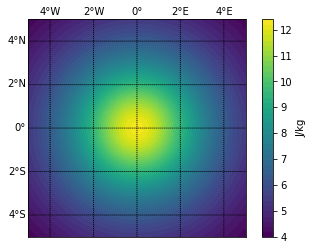

In [4]:
potential = tesseroid.potential(lons, lats, heights, model)

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')

x, y = bm(lats, lons)
bm.contourf(y.reshape(shape),
            x.reshape(shape),
            potential.reshape(shape),
            51)
bm.drawparallels(np.arange(-10, 10, 2), labels=[1, 0, 0, 0])
bm.drawmeridians(np.arange(-10, 10, 2), labels=[0, 0, 1, 0])
plt.colorbar(label="J/kg")
plt.show()

Now we can calculate all fields (potential, acceleration, and gradient tensor).

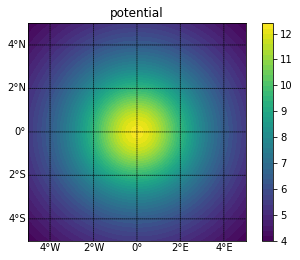

Time it took: 0.25s


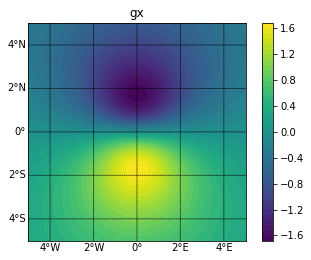

Time it took: 0.33s


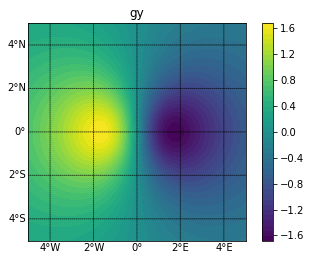

Time it took: 0.33s


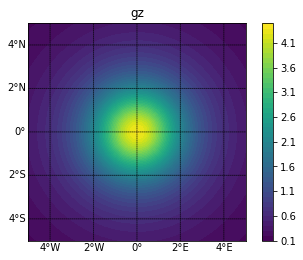

Time it took: 0.33s


In [5]:
fields = "potential gx gy gz".split()

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')
x, y = bm(lats, lons)

for f in fields:
    start = time.time()
    result = getattr(tesseroid, f)(lons, lats, heights, model)
    end = time.time()

    
    bm.contourf(y.reshape(shape),
                x.reshape(shape),
                result.reshape(shape),
                51)
    bm.drawparallels(np.arange(-10, 10, 2), labels=[1, 0, 0, 0])
    bm.drawmeridians(np.arange(-10, 10, 2), labels=[0, 0, 0, 1])
    plt.colorbar()
    plt.title(f)
    plt.show()
    print "Time it took: {:.2f}s".format(end - start)

## Tesseroid Mesh

Another option is to build our tesseroid model using a mesh of Tesseroids. We can set each tesseroid with variable density using a list of the functions. Moreover, we can mix constant and variable densities in the same mesh.

In [6]:
model = TesseroidMesh((-1, 1, -1, 1, top, bottom), shape=(1, 3, 3))

# Use the exponential density function for most tesseroids
density_list = [density for i in range(model.size)]
# the first will have a constant density
density_list[0] = 500
# and the second will use a new linear density function
def new_density(height):
    return -0.01*height
density_list[1] = new_density

# Add the densities to our model
model.addprop('density', density_list)

Define a computation grid.

In [7]:
lats, lons, heights = gridder.regular(area, shape, z=50000)

Calculate all fields from this mesh.

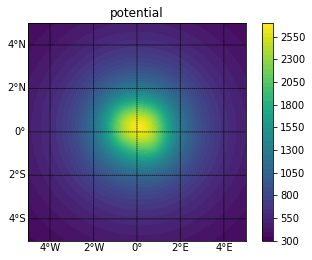

Time it took: 1.76s


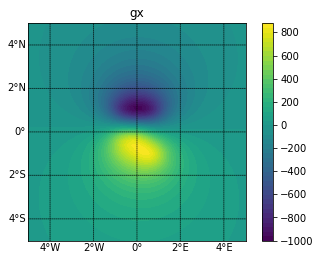

Time it took: 2.47s


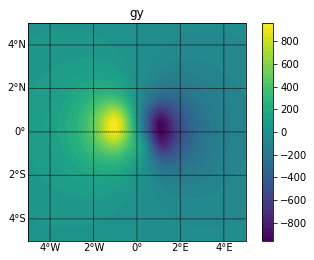

Time it took: 2.68s


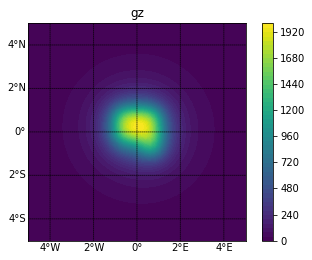

Time it took: 2.71s


In [8]:
fields = "potential gx gy gz".split()

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='l')
x, y = bm(lats, lons)

for f in fields:
    start = time.time()
    result = getattr(tesseroid, f)(lons, lats, heights, model)
    end = time.time()

    bm.contourf(y.reshape(shape),
                x.reshape(shape),
                result.reshape(shape),
                51)
    bm.drawparallels(np.arange(-10, 10, 2), labels=[1, 0, 0, 0])
    bm.drawmeridians(np.arange(-10, 10, 2), labels=[0, 0, 0, 1])
    plt.colorbar()
    plt.title(f)
    plt.show()
    print "Time it took: {:.2f}s".format(end - start)